# CASE STUDY-BANKING
# CREDIT CARD SPEND PREDICTION & IDENTIFY DRIVERS FOR SPEND

In [196]:
#Import packages
import os

import numpy as np
import pandas as pd
import datetime as dt
import pandas_profiling
import re as re

import scipy.stats as stats
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
from scipy import stats
import pylab

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocess
import sklearn.feature_selection as feature_selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest,f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
import copy

from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost
import statsmodels as st
import statsmodels.formula.api as smp

Populating the interactive namespace from numpy and matplotlib


C:\Users\anubh\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Importing Data

In [197]:
credit_card=pd.read_excel('Data Set.xlsx')

## Data Information

In [198]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(30), int64(98), object(2)
memory usage: 5.0+ MB


In [199]:
credit_card.columns

Index(['custid', 'region', 'townsize', 'gender', 'age', 'agecat', 'birthmonth',
       'ed', 'edcat', 'jobcat',
       ...
       'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object', length=130)

In [200]:
 profile_report = pandas_profiling.ProfileReport(credit_card,      correlations={
         "pearson": {"calculate": True},
         "spearman": {"calculate": True},
         "kendall": {"calculate": True},
         "phi_k": {"calculate": True},
         "cramers": {"calculate": True},
     })

In [201]:
profile_report.to_file('profile_report.html')

Summarize dataset:   0%|          | 0/143 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Defining Y-Variable for analysis

In [202]:
credit_card['cc_spend'] = credit_card['cardspent'] + credit_card['card2spent']

In [203]:
credit_card.drop(['cardspent','card2spent'],axis=1,inplace=True)

## Removing Columns with missing values
*missing % > 25*  
Columns : lntollmon,lntollten,lnequipmon,lnequipten,lncardmon,lncardten,lnwiremon,lnwireten
## Removing Unique column
Column : custid

In [204]:
credit_card.drop(['lntollmon','lntollten','lnequipmon','lnequipten','lncardmon','lncardten','lnwiremon','lnwireten','custid'],axis=1,inplace=True)

## Separating Numerical and Categorical variables
*1. Creating text file : cat.txt from columns in file Data Dictionary*  
*2. Writing below script to extratct numerical and categorical variables*


In [205]:
cat_var = list()
drp = ['lntollmon','lntollten','lnequipmon','lnequipten','lncardmon','lncardten','lnwiremon','lnwireten','custid','cardspent','card2spent']
with open('cat.txt') as f:
    for line in f:
      if (line.strip() != '' and line.strip() not in drp):
        cat_var.append(line.strip())
cat_var

['region',
 'townsize',
 'gender',
 'agecat',
 'birthmonth',
 'edcat',
 'jobcat',
 'union',
 'employ',
 'empcat',
 'retire',
 'inccat',
 'default',
 'jobsat',
 'marital',
 'spousedcat',
 'homeown',
 'hometype',
 'address',
 'addresscat',
 'cars',
 'carown',
 'cartype',
 'carcatvalue',
 'carbought',
 'carbuy',
 'commute',
 'commutecat',
 'commutecar',
 'commutemotorcycle',
 'commutecarpool',
 'commutebus',
 'commuterail',
 'commutepublic',
 'commutebike',
 'commutewalk',
 'commutenonmotor',
 'telecommute',
 'reason',
 'polview',
 'polparty',
 'polcontrib',
 'vote',
 'card',
 'cardtype',
 'cardbenefit',
 'cardfee',
 'cardtenure',
 'cardtenurecat',
 'card2',
 'card2type',
 'card2benefit',
 'card2fee',
 'card2tenure',
 'card2tenurecat',
 'active',
 'bfast',
 'churn',
 'tollfree',
 'equip',
 'callcard',
 'wireless',
 'multline',
 'voice',
 'pager',
 'internet',
 'callid',
 'callwait',
 'forward',
 'confer',
 'ebill',
 'owntv',
 'ownvcr',
 'owndvd',
 'owncd',
 'ownpda',
 'ownpc',
 'ownipod',

In [206]:
drp = ['lntollmon','lntollten','lnequipmon','lnequipten','lncardmon','lncardten','lnwiremon','lnwireten','custid','cardspent','card2spent']
num_var = list(set(credit_card.columns) - set(cat_var) - set(drp))
print(num_var, len(num_var))

['cardmon', 'spoused', 'tollten', 'lncreddebt', 'pets_freshfish', 'hourstv', 'pets_birds', 'pets_small', 'lninc', 'equipten', 'pets_saltfish', 'age', 'lnothdebt', 'tenure', 'cardten', 'debtinc', 'lnlongten', 'longmon', 'carvalue', 'wireten', 'pets_reptiles', 'equipmon', 'cc_spend', 'tollmon', 'pets_dogs', 'ed', 'lnlongmon', 'pets_cats', 'income', 'creddebt', 'othdebt', 'reside', 'commutetime', 'pets', 'wiremon', 'longten'] 36


In [207]:
cc_num=credit_card[num_var]
cc_cat=credit_card[cat_var]

#### Converting all data types to object for categorical data

In [208]:
cc_cat[cat_var] = cc_cat[cat_var].astype('object')

C:\Users\anubh\anaconda3\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [209]:
cc_cat.dtypes

region         object
townsize       object
gender         object
agecat         object
birthmonth     object
                ...  
ownfax         object
news           object
response_01    object
response_02    object
response_03    object
Length: 84, dtype: object

## Data Audit

In [210]:
def num_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_audit=cc_num.apply(lambda x: num_var_summary(x)).T
num_audit.to_csv('num_summary.csv')
display(num_audit)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
cardmon,5000.0,0.0,7.721925e+04,15.443850,13.750000,15.007569,2.252271e+02,0.000000,0.000000,0.000000,0.000000,0.000000,13.750000,22.750000,34.000000,42.000000,64.250000,188.500000
spoused,5000.0,0.0,3.056400e+04,6.112800,-1.000000,7.743518,5.996207e+01,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,14.000000,16.000000,18.000000,20.000000,24.000000
tollten,5000.0,0.0,2.889163e+06,577.832510,0.000000,949.151586,9.008887e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,885.450000,1918.955000,2620.212500,3977.270500,6923.450000
lncreddebt,4999.0,1.0,-6.521372e+02,-0.130454,-0.076106,1.273058,1.620678e+00,-6.597334,-3.401690,-2.291604,-1.737842,-0.952685,-0.076106,0.724665,1.458625,1.852297,2.658910,4.692014
pets_freshfish,5000.0,0.0,9.237000e+03,1.847400,0.000000,3.074801,9.454404e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,7.000000,8.000000,11.000000,16.000000
hourstv,5000.0,0.0,9.822500e+04,19.645000,20.000000,5.165609,2.668351e+01,0.000000,0.000000,12.000000,14.000000,17.000000,20.000000,23.000000,26.000000,28.000000,31.000000,36.000000
pets_birds,5000.0,0.0,5.520000e+02,0.110400,0.000000,0.494227,2.442607e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000
pets_small,5000.0,0.0,5.730000e+02,0.114600,0.000000,0.568798,3.235315e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000
lninc,5000.0,0.0,1.849955e+04,3.699909,3.637586,0.747072,5.581164e-01,2.197225,2.197225,2.564949,2.772589,3.178054,3.637586,4.204693,4.692261,4.990433,5.605839,6.978214
equipten,5000.0,0.0,2.350882e+06,470.176400,0.000000,912.220624,8.321465e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,510.162500,1912.325000,2600.990000,3679.457500,6525.300000


In [211]:
def cat_var_summary(x):
    return pd.Series([x.count(),x.isnull().sum(),x.unique()],
                    index=['N','NMISS','UniqueValues'])
cat_var_summary=cc_cat.apply(lambda x:cat_var_summary(x)).T
cat_var_summary.to_csv('cat_summary.csv')
display(cat_var_summary)

,N,NMISS,UniqueValues
region,5000,0,"[1, 5, 3, 4, 2]"
townsize,5000,0,"[2, 5, 4, 3, 1]"
gender,5000,0,"[1, 0]"
agecat,5000,0,"[2, 6, 3, 5, 4]"
birthmonth,5000,0,"[September, May, June, July, August, October, ..."
...,...,...,...
ownfax,5000,0,"[0, 1]"
news,5000,0,"[0, 1]"
response_01,5000,0,"[0, 1]"
response_02,5000,0,"[1, 0]"


## Handling Data
*1. Capping outlier for numerical data*  
*2. Hadling missinig value with Mean of data for numerical columns*  
*3. Handling missing value with mode of data for categorical columns*  

In [212]:
# Capping outliers
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01), upper=x.quantile(0.99))
    return x
cc_num=cc_num.apply(outlier_capping)

In [213]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x
cc_num=cc_num.apply(lambda x: Missing_imputation(x))

In [214]:
#Handling missings - Method2
def Cat_Missing_imputation(x):
    x = x.fillna(x.mode())
    return x
cc_cat=cc_cat.apply(lambda x: Cat_Missing_imputation(x))

#### Consolidating the handled cat and num data in a final table

In [215]:
cc_final = pd.concat([cc_num, cc_cat], axis=1)

In [216]:
cc_final.head()

,cardmon,spoused,tollten,lncreddebt,pets_freshfish,hourstv,pets_birds,pets_small,lninc,equipten,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,14.25,-1,161.05,0.183079,0,13,0,0,3.433987,126.1,...,0,0,0,1,1,0,0,0,1,0
1,16.00,-1,0.00,0.200505,6,18,0,0,2.708050,1975.0,...,1,1,1,1,1,1,1,0,0,0
2,23.00,13,0.00,-0.074056,0,21,0,0,3.555348,0.0,...,1,0,0,0,0,0,1,0,0,0
3,21.00,18,0.00,-3.401690,0,26,0,0,2.995732,0.0,...,1,0,1,1,1,0,1,1,0,0
4,17.25,13,387.70,-1.538705,0,27,0,0,3.135494,0.0,...,1,0,1,0,1,0,0,0,1,0


In [217]:
# dummy encoding columns
cc_final = pd.get_dummies(cc_final,['birthmonth'],drop_first=True)

## Dropping columns with low variance

In [218]:
cc_vars = cc_final.apply(lambda x: np.mean(x)/np.std(x) )

In [219]:
cc_vars.to_csv('col_variance.csv')

In [220]:
drop_cols = list(cc_vars[cc_vars < 0.05].index)
cc_final.drop(drop_cols, axis=1, inplace=True)

In [221]:
cc_final.to_csv('filtered_data.csv')
display(cc_final.head())

,cardmon,spoused,tollten,pets_freshfish,hourstv,pets_birds,pets_small,lninc,equipten,pets_saltfish,...,birthmonth_December,birthmonth_February,birthmonth_January,birthmonth_July,birthmonth_June,birthmonth_March,birthmonth_May,birthmonth_November,birthmonth_October,birthmonth_September
0,14.25,-1,161.05,0,13,0,0,3.433987,126.1,0,...,0,0,0,0,0,0,0,0,0,1
1,16.00,-1,0.00,6,18,0,0,2.708050,1975.0,0,...,0,0,0,0,0,0,1,0,0,0
2,23.00,13,0.00,0,21,0,0,3.555348,0.0,0,...,0,0,0,0,1,0,0,0,0,0
3,21.00,18,0.00,0,26,0,0,2.995732,0.0,0,...,0,0,0,0,0,0,1,0,0,0
4,17.25,13,387.70,0,27,0,0,3.135494,0.0,0,...,0,0,0,1,0,0,0,0,0,0


In [222]:
data_ml = copy.deepcopy(cc_final)

## Checking for distribution of our Y-variable i.e. cc_spend(credit card spend)

C:\Users\anubh\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


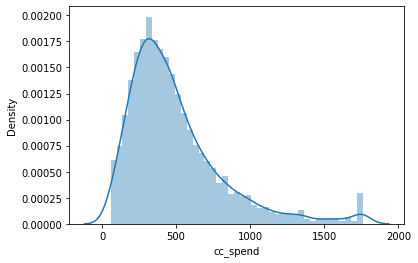

In [189]:
sns.distplot(cc_final.cc_spend)
plt.show()

#### As we could observe that the data is right skewed so we will take log to achieve a normal distribution

In [190]:
cc_final['log_cc_spend']=np.log(cc_final['cc_spend'])

C:\Users\anubh\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


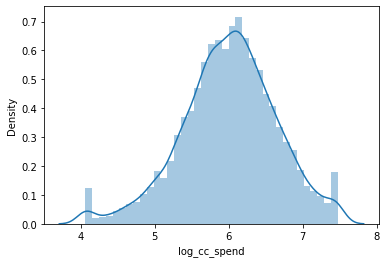

In [88]:
sns.distplot(cc_final.log_cc_spend)
plt.show()

## Feature Engineering for Variable Reduction

#### Correlation Matrix

In [89]:
corr_mat = cc_num.corr()
corr_mat.to_csv('correlation_matrix.csv')

In [90]:
corr_mat

,cardmon,spoused,tollten,lncreddebt,pets_freshfish,hourstv,pets_birds,pets_small,lninc,equipten,...,lnlongmon,pets_cats,income,creddebt,othdebt,reside,commutetime,pets,wiremon,longten
cardmon,1.000000,0.084453,0.341592,0.071361,0.010817,0.013073,-0.013676,-0.004159,0.137613,0.149692,...,0.419371,-0.011345,0.164969,0.103600,0.122684,-0.035345,-0.020791,0.009325,0.218523,0.437778
spoused,0.084453,1.000000,0.089339,0.005575,0.003910,0.028678,-0.020616,0.002415,0.045417,0.108972,...,0.149720,-0.001039,0.035491,0.002226,0.016854,0.610847,-0.002318,-0.001444,0.072966,0.128186
tollten,0.341592,0.089339,1.000000,0.131410,0.022030,0.019978,-0.007554,0.012433,0.254969,0.224215,...,0.391296,-0.015607,0.285782,0.170792,0.205918,-0.026685,-0.038167,0.019927,0.380052,0.378476
lncreddebt,0.071361,0.005575,0.131410,1.000000,-0.011220,0.040357,0.005590,0.003216,0.583823,0.101901,...,0.096325,-0.002678,0.531268,0.774916,0.556184,-0.048185,-0.030551,-0.009833,0.113942,0.086909
pets_freshfish,0.010817,0.003910,0.022030,-0.011220,1.000000,0.018532,-0.021461,0.019518,-0.000392,0.019648,...,0.023086,0.001610,0.005421,-0.012296,0.007740,-0.009723,-0.000340,0.898582,0.011062,0.024796
hourstv,0.013073,0.028678,0.019978,0.040357,0.018532,1.000000,0.002526,-0.005101,0.108643,0.021843,...,0.033940,0.001690,0.055100,0.032770,0.035490,0.027196,0.004992,0.019436,0.005340,0.010041
pets_birds,-0.013676,-0.020616,-0.007554,0.005590,-0.021461,0.002526,1.000000,-0.003118,0.010130,-0.026651,...,-0.006434,-0.007314,0.001840,-0.004893,-0.003970,-0.005058,0.009096,0.117926,0.002243,-0.004363
pets_small,-0.004159,0.002415,0.012433,0.003216,0.019518,-0.005101,-0.003118,1.000000,0.010353,0.030549,...,0.005986,-0.001543,-0.008239,-0.002966,-0.003381,0.000359,0.008824,0.180202,0.023795,0.000602
lninc,0.137613,0.045417,0.254969,0.583823,-0.000392,0.108643,0.010130,0.010353,1.000000,0.159243,...,0.164161,0.002866,0.898172,0.566972,0.636798,-0.057788,-0.025591,0.005846,0.217838,0.135259
equipten,0.149692,0.108972,0.224215,0.101901,0.019648,0.021843,-0.026651,0.030549,0.159243,1.000000,...,0.227982,0.009694,0.164405,0.103360,0.125057,-0.006146,-0.010426,0.026079,0.511777,0.181681


<AxesSubplot:>

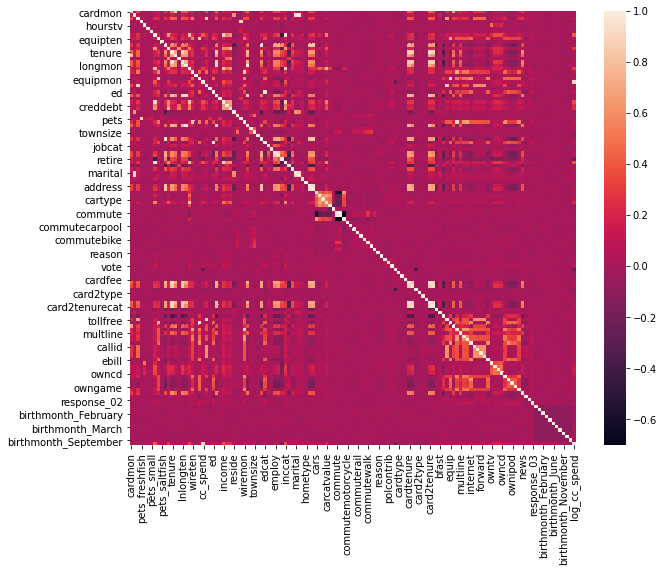

In [91]:
plt.figure(figsize = (10, 8))
sns.heatmap(cc_final.corr())

## Columns with correlation greater than 0.1 with credit card spend

In [92]:
corr_var=((corr_mat['cc_spend'][abs(corr_mat['cc_spend']) > 0.1]))
corr_var

lncreddebt    0.247816
lninc         0.396852
lnothdebt     0.266588
carvalue      0.319367
wireten       0.100014
cc_spend      1.000000
ed            0.100943
income        0.377200
creddebt      0.248547
othdebt       0.272972
Name: cc_spend, dtype: float64

## F- Regression

In [93]:
feature =cc_final[cc_final.columns.difference( ['log_cc_spend', 'cc_spend'] )]
target = cc_final['log_cc_spend']
F_values, p_values  = f_regression(feature, target)

In [94]:
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(feature.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results.sort_values(by=['F_Value'], ascending=False, inplace=True)
f_reg_results

,Variable,F_Value,P_Value
76,lninc,979.942213,0.000
71,inccat,850.969533,0.000
72,income,724.662085,0.000
40,carvalue,519.265495,0.000
79,lnothdebt,405.447398,0.000
...,...,...,...
12,birthmonth_March,0.008795,0.925
25,card2benefit,0.007779,0.930
9,birthmonth_January,0.000866,0.977
36,cardtype,0.000029,0.996


In [95]:
f_reg_results['P_Value'] = f_reg_results.P_Value.astype('float')
f_var=list((f_reg_results['Variable'][(f_reg_results['P_Value']) == 0.00]))
f_var

['lninc',
 'inccat',
 'income',
 'carvalue',
 'lnothdebt',
 'othdebt',
 'card',
 'creddebt',
 'carcatvalue',
 'retire',
 'owndvd',
 'ownvcr',
 'owncd',
 'ed',
 'wireten',
 'empcat',
 'edcat',
 'wiremon',
 'tollten',
 'owntv',
 'equipten',
 'gender',
 'card2',
 'tollmon',
 'cardtenurecat',
 'addresscat',
 'carown',
 'wireless',
 'internet',
 'equipmon',
 'ownpda',
 'homeown',
 'employ',
 'card2tenurecat',
 'jobsat',
 'ownfax',
 'response_03',
 'lnlongten',
 'pager',
 'card2tenure',
 'callwait',
 'vote',
 'callid',
 'confer',
 'tollfree',
 'cardtenure',
 'tenure',
 'equip',
 'forward']

## Recursive Feature Engineering

In [96]:
lm = RandomForestRegressor()
rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(feature, target)

In [97]:
rfe_var=list(feature.columns[rfe.support_])

In [98]:
rfe_var

['address',
 'age',
 'card',
 'card2',
 'cardmon',
 'carvalue',
 'commutetime',
 'creddebt',
 'debtinc',
 'hourstv',
 'income',
 'lninc',
 'lnlongten',
 'longmon',
 'othdebt']

## Select K-Best

In [99]:
Kbest = SelectKBest(f_classif,k=15).fit(feature,target)

In [100]:
skb_var = list(feature.columns[Kbest.get_support()])

In [101]:
skb_var

['birthmonth_August',
 'birthmonth_May',
 'birthmonth_September',
 'card2',
 'card2benefit',
 'default',
 'ed',
 'edcat',
 'inccat',
 'lnlongten',
 'lnothdebt',
 'ownfax',
 'ownpda',
 'pets_saltfish',
 'response_03']

In [102]:
final_var=[]
imp=[]
for i in feature.columns.tolist():
    if (i in corr_var or i in f_var or i in rfe_var or i in skb_var):
        final_var.append(i)
    if (i in f_var and i in rfe_var):
        imp.append(i) 
imp

['card',
 'card2',
 'carvalue',
 'creddebt',
 'income',
 'lninc',
 'lnlongten',
 'othdebt']

## Variance Inflation Factor

In [103]:
final_var= [#'address',
 'addresscat',
 'age',
 'birthmonth_August',
 'birthmonth_May',
 'birthmonth_September',
 'callid',
 'callwait',
#  'carcatvalue',
 'card',
 'card2',
 'card2benefit',
#  'card2tenure',
 'card2tenurecat',
 'cardmon',
#  'cardtenure',
 'cardtenurecat',
 'carown',
 'carvalue',
 'commutetime',
 'confer',
 'creddebt',
 'debtinc',
 'default',
#  'ed',
 'edcat',
 'empcat',
#  'employ',
 'equip',
#  'equipmon',
 'equipten',
 'forward',
 'gender',
 'homeown',
 'hourstv',
 'inccat',
 'income',
 'internet',
 'jobsat',
#  'lninc',
#  'lnlongmon',
 'lnlongten',
 'lnothdebt',
 'longten',
 'othdebt',
 'owncd',
 'owndvd',
 'ownfax',
 'ownpda',
 'owntv',
 'ownvcr',
 'pager',
 'pets_saltfish',
 'response_03',
 'retire',
#  'tenure',
 'tollfree',
#  'tollmon',
 'tollten',
 'vote',
 'wireless',
#  'wiremon',
 'wireten']
from patsy import dmatrices
y, X = dmatrices(formula_like='log_cc_spend ~' + '+'.join(final_var), data= cc_final,return_type='dataframe')


In [104]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["feature"] = X.columns

In [105]:
vif.sort_values(by='VIF_Factor', ascending=False)

,VIF_Factor,feature
0,179.831222,Intercept
30,10.173286,income
11,8.785624,card2tenurecat
13,8.550413,cardtenurecat
29,7.438079,inccat
33,6.617858,lnlongten
34,6.510457,lnothdebt
15,5.863683,carvalue
2,5.574026,age
19,5.322700,debtinc


## Modelling

#### Consolidating final table and Linear regression

In [106]:
cc_model= pd.concat([X.drop(["Intercept"], axis=1),target],axis=1)
cc_model.head()

,addresscat,age,birthmonth_August,birthmonth_May,birthmonth_September,callid,callwait,card,card2,card2benefit,...,pager,pets_saltfish,response_03,retire,tollfree,tollten,vote,wireless,wireten,log_cc_spend
0,1.0,20.0,0.0,0.0,1.0,0.0,1.0,3.0,5.0,1.0,...,1.0,0.0,0.0,0.0,1.0,161.05,1.0,0.0,0.00,5.007029
1,1.0,22.0,0.0,1.0,0.0,1.0,0.0,2.0,4.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,1683.55,4.350794
2,5.0,67.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,5.886021
3,2.0,23.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,5.884464
4,2.0,26.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,387.70,0.0,1.0,410.80,6.230147


In [107]:
train, test = train_test_split(cc_model, test_size=0.3, random_state=123)

In [108]:
eqn='log_cc_spend ~ ' + '+'.join(X.drop(["Intercept"], axis=1).columns)
print(eqn)
print(X.columns)

log_cc_spend ~ addresscat+age+birthmonth_August+birthmonth_May+birthmonth_September+callid+callwait+card+card2+card2benefit+card2tenurecat+cardmon+cardtenurecat+carown+carvalue+commutetime+confer+creddebt+debtinc+default+edcat+empcat+equip+equipten+forward+gender+homeown+hourstv+inccat+income+internet+jobsat+lnlongten+lnothdebt+longten+othdebt+owncd+owndvd+ownfax+ownpda+owntv+ownvcr+pager+pets_saltfish+response_03+retire+tollfree+tollten+vote+wireless+wireten
Index(['Intercept', 'addresscat', 'age', 'birthmonth_August', 'birthmonth_May',
       'birthmonth_September', 'callid', 'callwait', 'card', 'card2',
       'card2benefit', 'card2tenurecat', 'cardmon', 'cardtenurecat', 'carown',
       'carvalue', 'commutetime', 'confer', 'creddebt', 'debtinc', 'default',
       'edcat', 'empcat', 'equip', 'equipten', 'forward', 'gender', 'homeown',
       'hourstv', 'inccat', 'income', 'internet', 'jobsat', 'lnlongten',
       'lnothdebt', 'longten', 'othdebt', 'owncd', 'owndvd', 'ownfax',
      

In [109]:
ols_model = smp.ols(formula = eqn, data=train)
ols_model_output = ols_model.fit()
print(ols_model_output.summary())

                            OLS Regression Results                            
Dep. Variable:           log_cc_spend   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     23.99
Date:                Sat, 30 Jan 2021   Prob (F-statistic):          1.80e-187
Time:                        18:18:38   Log-Likelihood:                -2960.6
No. Observations:                3500   AIC:                             6025.
Df Residuals:                    3448   BIC:                             6345.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.3254 

In [110]:
p_sel = list(ols_model_output.pvalues[ols_model_output.pvalues < 0.05].index)
'+'.join(p_sel)

'Intercept+card+card2+edcat+equip+equipten+gender+inccat+income+internet+owndvd+retire'

## Model2 : Eliminating columns with P-value more then 0.05

In [111]:
eqn1='log_cc_spend ~ card+card2+edcat+equip+equipten+gender+inccat+income+internet+owndvd+retire'

In [112]:
ols_model = smp.ols(formula = eqn1, data=train)
ols_model_output = ols_model.fit()

In [113]:
print(ols_model_output.summary())

                            OLS Regression Results                            
Dep. Variable:           log_cc_spend   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     108.4
Date:                Sat, 30 Jan 2021   Prob (F-statistic):          2.98e-213
Time:                        18:18:38   Log-Likelihood:                -2977.4
No. Observations:                3500   AIC:                             5979.
Df Residuals:                    3488   BIC:                             6053.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2402      0.062    101.115      0.0

## Model Verification using different metrics

In [114]:
train_predicted = np.exp(ols_model_output.predict(train))
test_predicted = np.exp(ols_model_output.predict(test))

In [115]:
#Metrics (MAPE, RMSE, MSE, RMSPE)
train_actual = np.exp(train.log_cc_spend)
test_actual = np.exp(test.log_cc_spend)


In [116]:
train_MAPE = np.mean(np.abs(train_actual-train_predicted)/train_actual)
test_MAPE  = np.mean(np.abs(test_actual-test_predicted)/test_actual)

In [117]:
print('Train data MAPE : ',train_MAPE)
print('Test data MAPE : ',test_MAPE)

Train data MAPE :  0.5235698210583778
Test data MAPE :  0.4852872716165043


In [118]:
train_RMSE = np.sqrt(np.mean(np.square(train_actual-train_predicted)))
test_RMSE  = np.sqrt(np.mean(np.square(test_actual-test_predicted)))

In [119]:
print('Train data RMSE : ',train_RMSE)
print('Test data RMSE : ',test_RMSE)

Train data RMSE :  284.93923376207545
Test data RMSE :  287.9343093598406


In [120]:
train_RMSPE = np.sqrt(np.mean(np.square((train_actual-train_predicted)/train_actual)))
test_RMSPE  = np.sqrt(np.mean(np.square((test_actual-test_predicted)/test_actual)))

In [121]:
print('Train data RMSPE : ',train_RMSPE)
print('Test data RMSPE : ',test_RMSPE)

Train data RMSPE :  0.8594008560079353
Test data RMSPE :  0.7917863878411412


In [122]:
np.corrcoef(train_actual, train_predicted)

array([[1.        , 0.53344016],
       [0.53344016, 1.        ]])

In [123]:
np.corrcoef(test_actual, test_predicted)

array([[1.        , 0.45825804],
       [0.45825804, 1.        ]])

## Residual analysis and check for normality of residuals

In [124]:
#errors
train_errors = train_actual-train_predicted
test_errors = test_actual-test_predicted

C:\Users\anubh\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

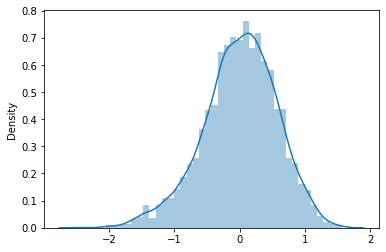

In [125]:
sns.distplot(ols_model_output.resid)

In [126]:
np.corrcoef(train_actual, train_errors)

array([[1.        , 0.88830965],
       [0.88830965, 1.        ]])

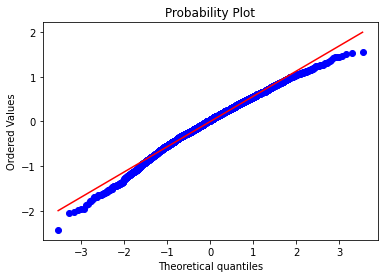

In [127]:
stats.probplot(ols_model_output.resid, dist = 'norm', plot = pylab)
pylab.show()

## Decile Analysis

In [128]:
train_results = pd.concat([train_actual, train_predicted], axis=1)
test_results = pd.concat([test_actual, test_predicted], axis=1)
train_results.columns = ['actual', 'pred']
test_results.columns = ['actual', 'pred']

In [129]:
# For Train data
train_results['Deciles']=pd.qcut(train_results['pred'],10, labels=False)
train_res = train_results.groupby(['Deciles']).apply(mean)[['actual','pred']]
train_res.to_csv('train_deciles.csv')
display(train_res)

,actual,pred
Deciles,,
0,293.271976,230.442803
1,327.720874,285.836750
2,367.872023,319.479741
3,409.425850,350.869902
4,413.627393,380.497505
5,457.101986,411.954444
6,493.795850,446.649326
7,588.709592,492.005796
8,678.550975,567.033140


In [130]:
# For Test Data
test_results['Deciles']=pd.qcut(test_results['pred'],10, labels=False)
test_res = test_results.groupby(['Deciles']).apply(mean)[['actual','pred']]
test_res.to_csv('test_deciles.csv')
display(test_res)

,actual,pred
Deciles,,
0,298.074203,235.308053
1,384.821835,291.500569
2,386.253251,327.030113
3,390.991425,357.787154
4,431.114481,389.363411
5,488.544667,420.943076
6,572.493444,457.439024
7,597.032346,500.907276
8,664.475981,568.256420


## Machine Learning

In [223]:
Ind_col = data_ml.columns.difference(['cc_spend'])
train_x, test_x, train_y, test_y = train_test_split(data_ml[Ind_col],data_ml.cc_spend, test_size=0.3, random_state=6)


### Decision Trees :

In [224]:
#Model building

param_grid = {'max_depth': np.arange(2, 5),
             'max_features': np.arange(4,7)}
data_tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 3)
data_tree.fit(train_x,train_y)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([2, 3, 4]),
                         'max_features': array([4, 5, 6])},
             pre_dispatch='2*n_jobs', r

In [225]:
#Predicting values for both training and testing data sets
tree_train_pred= data_tree.predict(train_x)
tree_test_pred=data_tree.predict(test_x)

In [226]:
#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y -tree_train_pred)/train_y)
print(MAPE_train)
MAPE_test = np.mean(np.abs(test_y- tree_test_pred)/test_y)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,tree_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,tree_test_pred))
print(RMSE_test)

MAPE values for training and testing data :
0.6365454140114536
0.6422696600804859

RMSE values for training and testing data :
288.60429591129315
280.8312108270342


###  Random Forest

In [227]:

pargrid_ada = {'n_estimators': [50,60,70,80,100],
               'max_depth':[2,3,4]}

data_rf = GridSearchCV(estimator=RandomForestRegressor(), 
                        param_grid=pargrid_ada, 
                        cv=3,n_jobs=-1)
data_rf.fit(train_x,train_y)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [228]:
#Predicting values for both training and testing data sets
rf_train_pred=data_rf.predict(train_x)
rf_test_pred=data_rf.predict(test_x)

In [229]:
#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y - rf_train_pred)/train_y)
print(MAPE_train)
MAPE_test = np.mean(np.abs(test_y- rf_test_pred)/test_y)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,rf_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,rf_test_pred))
print(RMSE_test)

MAPE values for training and testing data :
0.5634457543924025
0.5668721973558019

RMSE values for training and testing data :
258.99767251335635
258.56799944733416


### XGBoost

In [230]:
pargrid_xg = {'n_estimators': [60,70,80,100,120],
               'max_depth':[2,3,4,5]}

gscv_xg = GridSearchCV(estimator=xgboost.XGBRegressor(), 
                        param_grid=pargrid_xg, 
                        cv=3,n_jobs=-1)

data_xg=gscv_xg.fit(train_x, train_y)

In [231]:
#Predicting values for both training and testing data sets
xg_train_pred=data_xg.predict(train_x)
xg_test_pred=data_xg.predict(test_x)

In [232]:
#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y - xg_train_pred)/train_y)
print(MAPE_train)
MAPE_test = np.mean(np.abs(test_y- xg_test_pred)/test_y)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,xg_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,xg_test_pred))
print(RMSE_test)

MAPE values for training and testing data :
0.5323052443165154
0.5486034199371037

RMSE values for training and testing data :
246.3891064129548
255.36068445903092


In [233]:
gscv_xg.best_estimator_.feature_importances_
list(zip(train_x.columns,gscv_xg.best_estimator_.feature_importances_ ))

[('active', 0.008850616),
 ('address', 0.0),
 ('addresscat', 0.0),
 ('age', 0.011227387),
 ('agecat', 0.0),
 ('bfast', 0.0),
 ('birthmonth_August', 0.0),
 ('birthmonth_December', 0.019242365),
 ('birthmonth_February', 0.0),
 ('birthmonth_January', 0.0),
 ('birthmonth_July', 0.0),
 ('birthmonth_June', 0.0),
 ('birthmonth_March', 0.0),
 ('birthmonth_May', 0.0),
 ('birthmonth_November', 0.0),
 ('birthmonth_October', 0.006366166),
 ('birthmonth_September', 0.0),
 ('callcard', 0.0),
 ('callid', 0.0),
 ('callwait', 0.0),
 ('carbought', 0.0),
 ('carbuy', 0.0032970244),
 ('carcatvalue', 0.0),
 ('card', 0.17908876),
 ('card2', 0.08829742),
 ('card2benefit', 0.0034859702),
 ('card2fee', 0.011156086),
 ('card2tenure', 0.017504277),
 ('card2tenurecat', 0.0),
 ('card2type', 0.011904264),
 ('cardbenefit', 0.0),
 ('cardfee', 0.0),
 ('cardmon', 0.016598245),
 ('cardten', 0.010141401),
 ('cardtenure', 0.024124485),
 ('cardtenurecat', 0.0),
 ('cardtype', 0.008694301),
 ('carown', 0.0),
 ('cars', 0.0),
 

In [234]:
model = gscv_xg.best_estimator_

coefficients = pd.DataFrame()
coefficients['Column'] = train_x.columns
coefficients['Coeff'] = model.feature_importances_
coefficients = coefficients.sort_values('Coeff', ascending=False)
coefficients = coefficients.head(15).reset_index(drop=True)


<AxesSubplot:xlabel='Column'>

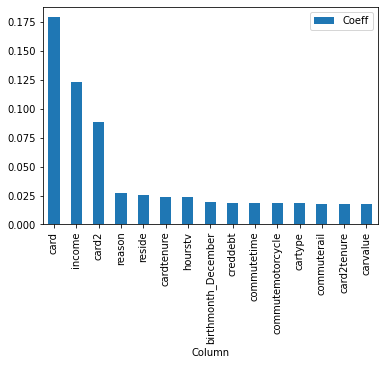

In [235]:
coefficients.plot(x='Column', y='Coeff', kind='bar')

In [241]:
coefficients.to_csv('coefficient.csv')